# 3 classic ML algorithms
## 1.Linear regression

[intercept=True, positive=True, scale=True]  MSE=0.2105
[intercept=True, positive=True, scale=False]  MSE=0.2105
[intercept=True, positive=False, scale=True]  MSE=0.1786
[intercept=True, positive=False, scale=False]  MSE=0.1786
[intercept=False, positive=True, scale=True]  MSE=0.2105
[intercept=False, positive=True, scale=False]  MSE=0.2090
[intercept=False, positive=False, scale=True]  MSE=0.1786
[intercept=False, positive=False, scale=False]  MSE=0.1779

 BEST LINEAR REGRESSION CONFIG
{'fit_intercept': False, 'positive': False, 'scale_features': False, 'mse': 0.17785403082489248, 'model': LinearRegression(fit_intercept=False), 'X_train_scaled':       OverallQual  GrLivArea  GarageCars  ExterQual  GarageArea  TotalBsmtSF  \
816     -0.795151  -0.966045   -1.026858   0.663451   -0.926303    -0.112710   
438     -0.795151  -1.563798   -1.026858   0.663451   -0.566038    -1.407872   
940     -0.071836   0.404600    0.311725   0.663451    0.472648     1.529045   
96       0.651479   0.138

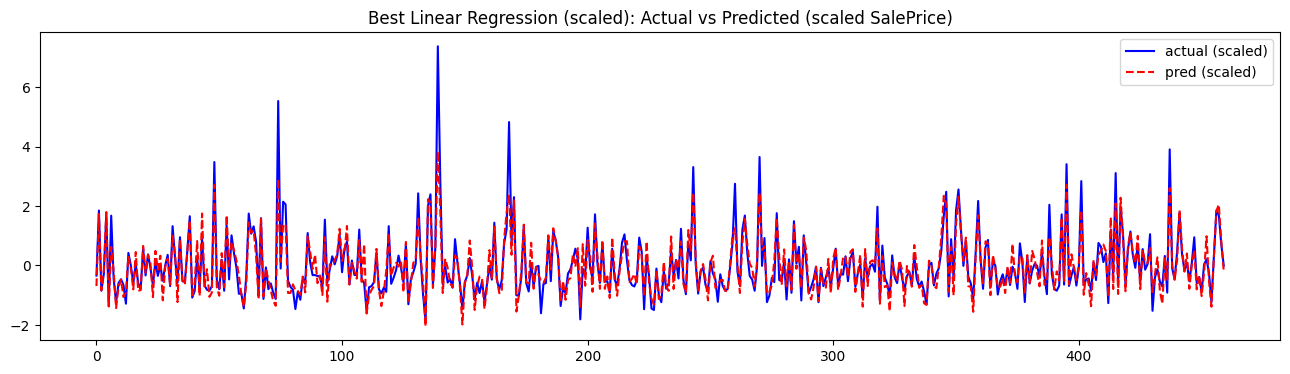

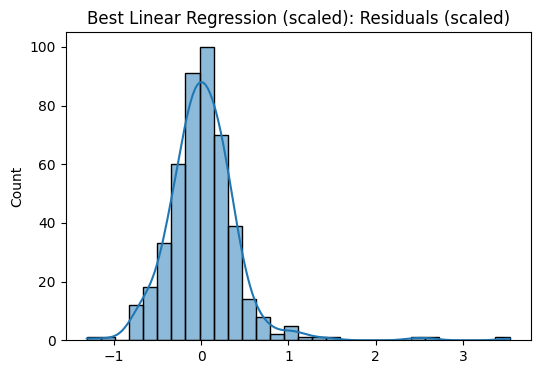

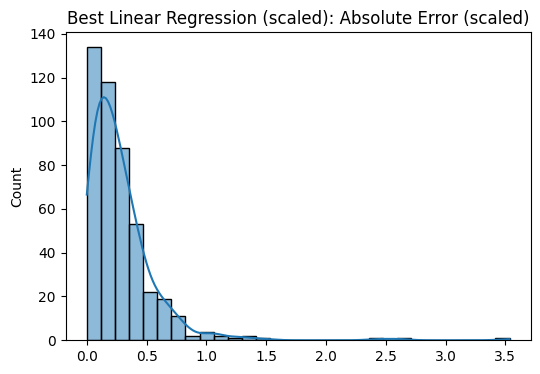

In [1]:
# ================================
# Imports
# ================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error


CSV_PATH = "train.csv"


# ================================
# 1. Li (2023) Preprocessing
# ================================
def preprocess_and_split_li2023(csv_path=CSV_PATH, top_k=30, random_state=42):
    df = pd.read_csv(csv_path)

    # Drop columns (Li 2023)
    cols_to_drop = [
        "Alley", "YearRemodAdd", "FireplaceQu", "PoolQC",
        "Fence", "MasVnrType", "MiscFeature", "Id"
    ]
    df = df.drop(columns=[c for c in cols_to_drop if c in df.columns])

    target = "SalePrice"
    y = df[target]
    X = df.drop(columns=[target])

    # Split numeric & categorical
    numeric_cols = X.select_dtypes(include=["int64", "float64"]).columns
    categorical_cols = X.select_dtypes(include=["object"]).columns

    # Handle missing
    X[numeric_cols] = X[numeric_cols].apply(lambda col: col.fillna(col.mean()))
    X[categorical_cols] = X[categorical_cols].fillna("NONE")

    # Ordinal encode categoricals
    enc = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
    if len(categorical_cols) > 0:
        X[categorical_cols] = enc.fit_transform(X[categorical_cols])

    # Standardize ALL features
    scaler_x = StandardScaler()
    X_scaled = pd.DataFrame(scaler_x.fit_transform(X), columns=X.columns)
    X_scaled[target] = y.values

    # Select top-k correlated features
    corr = X_scaled.corr()[target].drop(target)
    top_features = corr.abs().sort_values(ascending=False).index[:top_k].tolist()
    X_final = X_scaled[top_features]
    y_final = y.copy()

    # 1000 / 460 split
    test_size = 460 / len(X_final)
    X_train, X_test, y_train, y_test = train_test_split(
        X_final, y_final,
        test_size=test_size, shuffle=True, random_state=random_state
    )

    # Scale TARGET (SalePrice)
    y_scaler = StandardScaler()
    y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1)).ravel()
    y_test_scaled = y_scaler.transform(y_test.values.reshape(-1, 1)).ravel()

    return {
        "X_train": X_train,
        "X_test": X_test,
        "y_train_scaled": y_train_scaled,
        "y_test_scaled": y_test_scaled,
        "y_test_raw": y_test,
        "y_scaler": y_scaler,
        "top_features": top_features
    }


# ================================
# 2. Evaluate in SCALED target space
# ================================
def evaluate_scaled(name, y_true_scaled, y_pred_scaled):

    mse = mean_squared_error(y_true_scaled, y_pred_scaled)
    mae = mean_absolute_error(y_true_scaled, y_pred_scaled)
    rmse = np.sqrt(mse)

    print(f"\n=== {name} (SCALED TARGET) ===")
    print(f"MSE:  {mse:.4f}")
    print(f"MAE:  {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")

    # Sequential plot (Li-style)
    plt.figure(figsize=(16,4))
    plt.plot(y_true_scaled, label="actual (scaled)", color="blue")
    plt.plot(y_pred_scaled, label="pred (scaled)", linestyle="--", color="red")
    plt.title(f"{name}: Actual vs Predicted (scaled SalePrice)")
    plt.legend()
    plt.show()

    # Residuals
    residuals = y_true_scaled - y_pred_scaled
    plt.figure(figsize=(6,4))
    sns.histplot(residuals, kde=True, bins=30)
    plt.title(f"{name}: Residuals (scaled)")
    plt.show()

    # Absolute error
    plt.figure(figsize=(6,4))
    sns.histplot(np.abs(residuals), kde=True, bins=30)
    plt.title(f"{name}: Absolute Error (scaled)")
    plt.show()


# ================================
# 3. Linear Regression Hyperparameter Tuning
# ================================
def tune_linear_regression(X_train, X_test, y_train_scaled, y_test_scaled):

    # Search space
    fit_intercepts = [True, False]
    positive_flags = [True, False]
    scale_features = [True, False]  # whether to re-scale X again

    best_mse = float("inf")
    best_cfg = None

    results = []

    for fit_int in fit_intercepts:
        for positive in positive_flags:
            for do_scale in scale_features:

                # Optionally scale X again
                if do_scale:
                    scaler = StandardScaler()
                    X_train_scaled = scaler.fit_transform(X_train)
                    X_test_scaled2 = scaler.transform(X_test)
                else:
                    X_train_scaled = X_train
                    X_test_scaled2 = X_test

                model = LinearRegression(
                    fit_intercept=fit_int,
                    positive=positive
                )

                model.fit(X_train_scaled, y_train_scaled)

                pred_scaled = model.predict(X_test_scaled2)
                mse = mean_squared_error(y_test_scaled, pred_scaled)

                results.append({
                    "fit_intercept": fit_int,
                    "positive": positive,
                    "scale_features": do_scale,
                    "mse": mse
                })

                if mse < best_mse:
                    best_mse = mse
                    best_cfg = {
                        "fit_intercept": fit_int,
                        "positive": positive,
                        "scale_features": do_scale,
                        "mse": mse,
                        "model": model,
                        "X_train_scaled": X_train_scaled,
                        "X_test_scaled": X_test_scaled2
                    }

                print(f"[intercept={fit_int}, positive={positive}, scale={do_scale}]  MSE={mse:.4f}")

    print("\n===================")
    print(" BEST LINEAR REGRESSION CONFIG")
    print("===================")
    print(best_cfg)

    return best_cfg


# ================================
# 4. Run search + evaluate best model
# ================================
data = preprocess_and_split_li2023(CSV_PATH)

X_train = data["X_train"]
X_test = data["X_test"]
y_train_scaled = data["y_train_scaled"]
y_test_scaled = data["y_test_scaled"]

best_cfg = tune_linear_regression(
    X_train, X_test,
    y_train_scaled, y_test_scaled
)

best_model = best_cfg["model"]
X_test_best = best_cfg["X_test_scaled"]

pred_scaled = best_model.predict(X_test_best)

evaluate_scaled("Best Linear Regression (scaled)", y_test_scaled, pred_scaled)
